In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
!pip install datasets transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from datasets import load_dataset

In [ ]:
from datasets import load_dataset,Dataset,DatasetDict
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/combined_dataset.csv')
data.head()
# Subtract 1 from each label
data['condition_label'] = data['condition_label'] - 1

data.to_csv('dataset.csv', index=False)

In [ ]:
data=load_dataset("csv",data_files="/content/dataset.csv")
data=data.rename_column("condition_label","label")
data=data.rename_column("medical_abstract","headline")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
data.set_format('pandas')
data=data['train'][:]

data.drop_duplicates(subset=['headline'],inplace=True)
data=data.reset_index()[['headline','label']]
data=Dataset.from_pandas(data)

# 80% train, 20% test + validation
train_testvalid = data.train_test_split(test_size=0.2,seed=15)

# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5,seed=15)

# gather everyone if you want to have a single DatasetDict
data = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

data

DatasetDict({
    train: Dataset({
        features: ['headline', 'label'],
        num_rows: 8981
    })
    test: Dataset({
        features: ['headline', 'label'],
        num_rows: 1123
    })
    valid: Dataset({
        features: ['headline', 'label'],
        num_rows: 1123
    })
})

In [ ]:
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=512
def tokenize(batch):
  return tokenizer(batch["headline"], truncation=True,max_length=512,padding=True)

tokenized_dataset = data.map(tokenize, batched=True)
tokenized_dataset

(…)co/roberta-base/resolve/main/config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

(…).co/roberta-base/resolve/main/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

(…).co/roberta-base/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)roberta-base/resolve/main/tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/8981 [00:00<?, ? examples/s]

Map:   0%|          | 0/1123 [00:00<?, ? examples/s]

Map:   0%|          | 0/1123 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['headline', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8981
    })
    test: Dataset({
        features: ['headline', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1123
    })
    valid: Dataset({
        features: ['headline', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1123
    })
})

In [ ]:
import tensorflow as tf


In [ ]:
tokenized_dataset.set_format('tf',
                            columns=['input_ids', 'attention_mask', 'label'])

# setting BATCH_SIZE to 64.
BATCH_SIZE = 8

def order(inp):
    '''
    This function will group all the inputs of BERT
    into a single dictionary and then output it with
    labels.
    '''
    data = list(inp.values())
    return {
        'input_ids': data[1],
        'attention_mask': data[2],

    }, data[0]

# converting train split of `tokenized_dataset` to tensorflow format
train_dataset = tf.data.Dataset.from_tensor_slices(tokenized_dataset['train'][:])
# set batch_size and shuffle
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000)
# map the `order` function
train_dataset = train_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

# ... doing the same for test set ...
test_dataset = tf.data.Dataset.from_tensor_slices(tokenized_dataset['test'][:])
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
model = TFAutoModel.from_pretrained("roberta-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
import tensorflow as tf

class roBERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes, dropout_rate=0.5):
        super().__init__()
        self.bert = bert_model
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        # BERT output (pooled_output) index may vary based on your BERT model implementation
        x = self.bert(inputs)[1]

        # Apply dropout during training
        x = self.dropout(x, training=training)

        return self.fc(x)

# Example usage:
# Replace 'your_bert_model' with the actual BERT model instance and adjust other parameters accordingly
classifier = BERTForClassification(model, num_classes=5)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [ ]:
history = classifier.fit(
    train_dataset,
    epochs=6
)

Epoch 1/6
1123/1123 [==============================] - 1145s 974ms/step - loss: 0.9209 - accuracy: 0.6370
Epoch 2/6
1123/1123 [==============================] - 1084s 965ms/step - loss: 0.6968 - accuracy: 0.7325
Epoch 3/6
1123/1123 [==============================] - 1084s 965ms/step - loss: 0.6043 - accuracy: 0.7707
Epoch 4/6
1123/1123 [==============================] - 1085s 966ms/step - loss: 0.5015 - accuracy: 0.8076
Epoch 5/6
1123/1123 [==============================] - 1083s 964ms/step - loss: 0.4170 - accuracy: 0.8384
Epoch 6/6
1123/1123 [==============================] - 1083s 964ms/step - loss: 0.3318 - accuracy: 0.8727


In [ ]:
classifier.evaluate(test_dataset)

141/141 [==============================] - 49s 329ms/step - loss: 0.8740 - accuracy: 0.7088


[0.8740360736846924, 0.7088156938552856]

In [ ]:
# Save the entire model as a TensorFlow SavedModel
classifier.save("/content/drive/MyDrive/robert_saved_model")


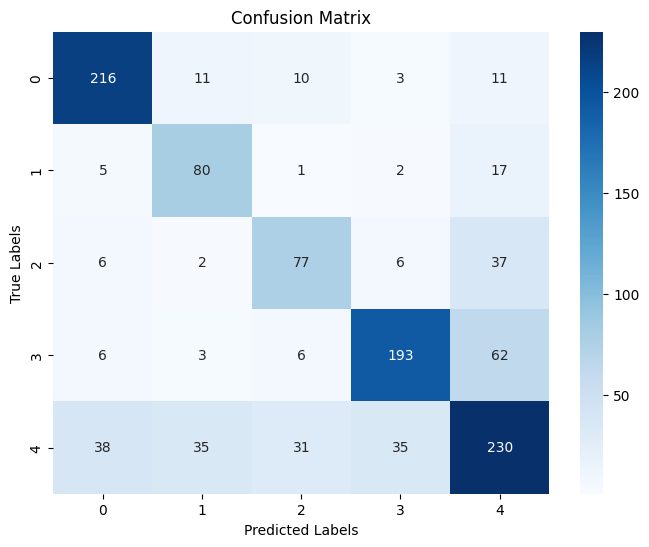

In [ ]:
model=tf.saved_model.load('/content/drive/MyDrive/robert_saved_model')
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def get_predictions(model, test_dataset):
    predictions = []
    true_labels = []
    for inputs, labels in test_dataset:
        preds = model(inputs)
        predictions.extend(tf.argmax(preds, axis=1).numpy())
        true_labels.extend(labels.numpy())
    return np.array(predictions), np.array(true_labels)

# Get predictions and true labels
predicted_labels, true_labels = get_predictions(model, test_dataset)

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()